# Model selection

Cross-validation is used here to select the best model. In this script it is used to test the best machine learning model for use in this context.

<u>Tests using the following models :</u>
* Linear regression
* Random forest regressor
* XGBoost
* Extra Trees Regressor

<u> The following variables are included in the model:</u>
* Weather variables (rain, temperature, windspeed)
* Time variables (Day of week, month, year, time of day, public holiday)
* Sensor environment variables (within a 500m buffer of the sensor):
    * Betweenness of the street 
    * Buildings in proximity to the sensor
    * Landmarks in proximity to the sensor  
    * Furniture in proximity to the sensor    
    * Lights in proximity to the sensor   

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor 
import xgboost as xgb
from sklearn.pipeline import Pipeline
import folium
import branca.colormap as cm
from eli5.sklearn import PermutationImportance
import joblib
import os
import psutil

from Functions import *

In [2]:
buffer_size_m = 500
input_csv ="../Cleaned_data/FormattedDataForModelling/formatted_data_for_modelling_allsensors_{}.csv".format(buffer_size_m)

## Run models with cross-validation

### Define the error metrics for the cross-validation to return, and the parameters of the cross validation

In [3]:
error_metrics = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_percentage_error']
cv_parameters = KFold(n_splits=2, random_state=1, shuffle=True)

In [4]:
lr_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['linear_regressor',LinearRegression()]])
rf_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['rf_regressor', RandomForestRegressor(random_state = 1, n_jobs = 10)]])
xgb_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['xgb_regressor',xgb.XGBRegressor(random_state=1, n_jobs = 16)]])
et_model_pipeline = Pipeline(steps=[['scaler',StandardScaler()],['et_regressor',ExtraTreesRegressor (random_state = 1, n_jobs = 16)]])

In [5]:
models_dict = {"rf_regressor":rf_model_pipeline}

### Prepare data for modelling

In [6]:
Xfull, Yfull, data_time_columns = prepare_x_y_data(input_csv)

In [9]:
sensor_ids = pd.read_csv(input_csv)['sensor_id']
Xfull['sensor_id'] = sensor_ids

### Remove year

In [7]:
# del Xfull['year']

### Choose which month_num and weekday_num option to include

In [10]:
# If using the dummy variables
# Xfull.drop(['Cos_month_num', 'Sin_month_num', 'Cos_weekday_num', 'Sin_weekday_num'], axis=1)
# If using the cyclical variables
Xfull.drop(['Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12'], axis=1, inplace = True)

### Remove spatial features

In [11]:
Xfull.drop(['betweenness', 'lights', 'street_inf', 'memorials', 'trees','bus-stops', 'tram-stops', 'metro-stations', 
            'taxi-ranks', 'big-car-parks', 'street_inf_Bicycle Rails', 'street_inf_Bollard','street_inf_Drinking Fountain',
            'street_inf_Floral Crate/Planter Box','street_inf_Horse Trough', 'street_inf_Information Pillar',
            'street_inf_Litter Bin', 'street_inf_Seat', 'street_inf_Tree Guard','landmarks_Community Use', 
            'landmarks_Mixed Use','landmarks_Place Of Assembly', 'landmarks_Place of Worship', 'landmarks_Retail', 
            'landmarks_Transport', 'landmarks_Education Centre','landmarks_Leisure/Recreation', 'landmarks_Office',
       'street_inf_Barbeque', 'street_inf_Hoop', 'street_inf_Picnic Setting', 'landmarks_Specialist Residential Accommodation',
       'landmarks_Vacant Land', 'landmarks_Purpose Built','landmarks_Health Services', 'avg_n_floors', 'buildings_Community Use',
       'buildings_Education', 'buildings_Entertainment', 'buildings_Events','buildings_Hospital/Clinic', 'buildings_Office', 'buildings_Parking',
       'buildings_Public Display Area', 'buildings_Residential','buildings_Retail', 'buildings_Storage', 'buildings_Unoccupied',
       'buildings_Working', 'buildings_Transport'], axis=1, inplace = True)

In [12]:
Xfull.columns

Index(['year', 'Temp', 'Humidity', 'Pressure', 'Rain', 'WindSpeed',
       'Rainfall amount (millimetres)', 'public_holiday', 'school_holiday',
       'Sin_time', 'Cos_time', 'Sin_month_num', 'Cos_month_num',
       'Sin_weekday_num', 'Cos_weekday_num', 'random', 'random_cat',
       'sensor_id'],
      dtype='object')

### Run model with cross validation

In [13]:
# Dataframe to store the scores for all the models
error_metric_scores = pd.DataFrame()

for model_name, model_pipeline in models_dict.items():
    print(model_name)
    # Use cross_validate to return the error scores associated with this model and this data
    start = time()
    model_output = cross_validate(model_pipeline, Xfull, Yfull, cv=cv_parameters, scoring=error_metrics, error_score="raise")
    end = time()
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    
    # Formulate the different error scores into a dataframe
    error_metrics_df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                  'mape': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                  'r2': round(abs(model_output['test_r2'].mean()),2), 
                  'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                 index =[model_name])
        
    # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
    error_metric_scores = error_metric_scores.append(error_metrics_df)
    # Save error scores for this distance to file
    #error_metrics_df.to_csv('Results/CV/ComparingModels/{}_{}m_error_metric_scores.csv'.format(model_name,buffer_size_m),index=False)    

# Save dataframes of error metrics for each buffer distance 
#error_metric_scores.to_csv('Results/CV/ComparingModels/comparingmodels_error_metric_scores.csv')   

rf_regressor
Ran in 7 minutes


### Print table showing error metrics associated with each model

In [14]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,64.33,1.665136e+15,0.93,131.26


In [15]:
error_metric_scores

,mae,mape,r2,rmse
rf_regressor,279.82,5.082449e+15,0.25,428.43


In [ ]:
#### Run cross_val_predict to get predictions
start = time()
predictions = cross_val_predict(model_pipeline, Xfull, Yfull,cv=cv_parameters)
end = time()
print('Ran cross_val_predict in {} minutes'.format(round((end - start)/60),2))

In [ ]:
# Convert to a dataframe
predictions_df=pd.DataFrame(predictions)
# Store the predictions
predictions_df.to_csv('Results/CV/RF_500m/predictions.csv',index=False)   

In [ ]:
predictions_df

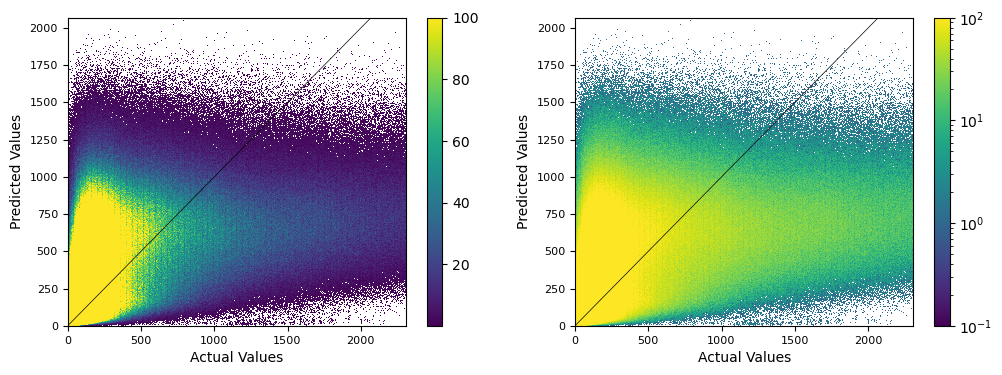

In [18]:
fig, axs = plt.subplots(ncols=2, figsize = (12,4))

# Plot with linear scale
using_datashader(axs[0], Yfull, predictions, 'linear')
axs[0].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[0].set_ylabel("Predicted Values", size=10)
axs[0].set_xlabel("Actual Values", size=10)
#axs[0].set_xlim([0, 2000])
#axs[0].set_ylim([0, 2000])
axs[0].tick_params(axis='both', which='major', labelsize=8)

# Plot with log scale
using_datashader(axs[1], Yfull, predictions, 'log')
axs[1].plot([Yfull.min(), Yfull.max()], [Yfull.min(), Yfull.max()], c='k', lw=0.5)
axs[1].set_ylabel("Predicted Values", size=10)
axs[1].set_xlabel("Actual Values", size=10)
# axs[1].set_xlim([0, 2000])
# axs[1].set_ylim([0, 2000]);
axs[1].tick_params(axis='both', which='major', labelsize=8)

In [20]:
def run_model_with_cv_and_predict(model,model_name, metrics, cv, X_data, Y_data):

    # Get list of all features
    feature_list = list(X_data.columns)
        
    # Perform cross validation, time how long it takes
    start = time()
    print("running cross_validate")
    model_output = cross_validate(model, X_data, Y_data, cv=cv, scoring=metrics ,return_estimator=True, error_score="raise")
    print("ran cross_validate")    
    
    print("running cross_val_predict")
    predictions = cross_val_predict(model, X_data,Y_data,cv=cv)
    print("ran cross_val_predict")   
    end = time()
    
    #  Create a dataframe containng scores for each performance metric
    df =pd.DataFrame({'mae': round(abs(model_output['test_neg_mean_absolute_error'].mean()),2), 
                      'map': round(abs(model_output['test_neg_mean_absolute_percentage_error'].mean()),2),
                      'r2': round(abs(model_output['test_r2'].mean()),2), 
                      'rmse': round(abs(model_output['test_neg_root_mean_squared_error'].mean()),2)},
                     index =[model_name])
    
    # Get the estimators 
    estimators = model_output['estimator']
    
    print('Ran in {} minutes'.format(round((end - start)/60),2))
    return [estimators, df, feature_list, predictions]   

In [25]:
# # Dataframe to store the scores for each model
# error_metric_scores = pd.DataFrame()

# # Dictionary to store dataframes of feature importance scores
# predictions_df = pd.DataFrame()

# # Dictionary to store dataframes of feature importance scores
# feature_importance_scores ={}

# # Run the model: return the estimators and a dataframe containing evaluation metrics
# estimators, error_metrics_df, feature_list, predictions = run_model_with_cv_and_predict(
#     model_pipeline, model_name, error_metrics, cv_parameters, Xfull, Yfull) 
# # Add evaluation metric scores for this model to the dataframe containing the metrics for each model
# error_metric_scores = error_metric_scores.append(error_metrics_df)

# predictions_df[model_name] =predictions

# # Create dataframe of feature importances (no feature importances for linear regression)
# if model_name != 'linear_regressor':
#     feature_importances = pd.DataFrame(index =[feature_list])
#     for idx,estimator in enumerate(estimators):
#             feature_importances['Estimator{}'.format(idx)] = estimators[idx][model_name].feature_importances_
#     feature_importance_scores["{}".format(model_name)] = feature_importances

# #         filename = 'PickleFiles/CV/{}_aggregatedmodel/{}_cv_estimators.pkl'.format(buffer_size_m, model_name)
# #         joblib.dump(estimators, filename)